<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/MultiLabel_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1145]:
import sys 
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')

In [1146]:
import pandas as pd
from pathlib import Path
import joblib
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab

import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter


from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
!pip install wandb -qq
import wandb

In [1147]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')   
  base_path = '/content/drive/MyDrive/NLP'
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fns')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fn')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1148]:
base_folder = Path(base_path)
assignment_fldr = base_folder/ 'assignment6'
custom_fldr = base_folder/ 'user-defined-fn'

#Check contents in data folder
for entries in custom_fldr.iterdir():
  print(entries.name)

data_preparation_imdb_rev0.py
.ipynb_checkpoints
__pycache__


In [1149]:
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')
sys.path = list(set(sys.path))

In [1150]:
sys.path

['/content',
 '',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/env/python',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP/user-defined-fns',
 '/content/drive/MyDrive/NLP/user-defined',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3.9/lib-dynload',
 '/content/drive/MyDrive/NLP/user-defined-fn',
 '/usr/lib/python39.zip',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.9']

In [1151]:
!pip install torchmetrics -qq

In [1152]:
from Trainer_v2 import Trainer
from ff_3_layer_sequential_model import MLPCustom

In [1153]:
from data_preparation_imdb_rev0 import *

In [1154]:
df_multilable_data = assignment_fldr/ 'df_multilabel_hw_cleaned.joblib'
multiLabel_Data = joblib.load(df_multilable_data)

In [1155]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [1156]:
multiLabel_Data.shape

(47427, 3)

In [1157]:
print(set(multiLabel_Data['Tag_Number']))

{'[1, 2, 8, 6, 4]', '[1, 3, 4]', '[2, 5]', '[0, 2, 9]', '[2, 3, 4]', '[8, 9]', '[0, 1, 6, 4]', '[1, 2, 6]', '[0, 3, 5]', '[0, 7]', '[0, 1, 5]', '[0, 2, 9, 5]', '[0, 5, 9]', '[2, 5, 3]', '[2, 8, 4]', '[5, 8]', '[0, 9, 5]', '[2, 3, 8]', '[9, 7]', '[4, 8]', '[8, 7]', '[0, 9, 6]', '[3, 4, 5]', '[3, 5, 8, 4]', '[1, 4]', '[2, 1, 7, 3]', '[3, 2]', '[0, 1, 2, 9]', '[5, 4]', '[0, 4]', '[1, 4, 6]', '[0, 3, 5, 9]', '[1, 6, 7]', '[5, 9]', '[2, 5, 7]', '[1, 2, 5]', '[1, 4, 7]', '[1, 2, 7]', '[8, 6]', '[3, 8, 9]', '[8, 4, 7]', '[2, 3]', '[3, 4, 5, 8]', '[1, 3]', '[5, 2]', '[1, 8, 4]', '[1, 2, 3, 4]', '[0, 1, 3]', '[4, 7]', '[1, 3, 5, 4]', '[0, 2, 3, 5, 9]', '[3, 7]', '[4, 9]', '[0, 1, 3, 6, 7]', '[2, 5, 9]', '[2, 3, 7]', '[1, 0, 6]', '[3, 9, 4]', '[0, 3, 4, 9]', '[0, 1, 3, 7]', '[5, 9, 4]', '[4, 6]', '[9, 5]', '[0, 1, 7]', '[9, 0]', '[0, 1, 3, 5]', '[3, 6]', '[1, 7]', '[2, 0]', '[2, 3, 5, 4]', '[0, 9]', '[3, 5, 4]', '[2, 8]', '[3, 8]', '[1, 2, 3, 7]', '[1, 3, 4, 5]', '[6, 3]', '[6, 2]', '[0, 3, 9]',

In [1158]:
import ast
# assume 'df' is your pandas DataFrame
multiLabel_Data['Tag_Number'] = multiLabel_Data['Tag_Number'].apply(lambda x: [int(i) for i in ast.literal_eval(x)])

In [1159]:
from sklearn.preprocessing import MultiLabelBinarizer

# assume 'labels' is your list of labels (i.e., 'Tag_Number' column after conversion to integers)
mlb = MultiLabelBinarizer()
multiLabel_Data['Tag_Number'] = mlb.fit_transform(multiLabel_Data['Tag_Number'])


In [1160]:
multiLabel_Data['Tag_Number']

0        1
1        0
2        1
3        0
4        0
        ..
47422    0
47423    0
47424    0
47425    0
47426    0
Name: Tag_Number, Length: 47427, dtype: int64

In [1161]:
multiLabel_Data['Tag_Number'].shape


(47427,)

In [1162]:
X_final = multiLabel_Data['cleaned_text'].values

In [1163]:
print(type(X_final), X_final.shape)

<class 'numpy.ndarray'> (47427,)


In [1164]:
y_final = multiLabel_Data['Tag_Number'].values
unique_labels = np.unique(y_final)
print(unique_labels)

[0 1]


In [1165]:
print(type(y_final), y_final.shape)

<class 'numpy.ndarray'> (47427,)


#Create Train/Test/Valid Split

In [1166]:
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4, stratify = y_final)

In [1167]:
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5, stratify = y_valid_test)

In [1168]:
print("Train set shape: ", X_train.shape, "Split %: ", len(X_train)/len(X_final))
print("Validation set shape: ", X_valid.shape,"Split %: ", len(X_valid)/len(X_final))
print("Test set shape: ", X_test.shape, "Split %: ", len(X_test)/len(X_final))

Train set shape:  (28456,) Split %:  0.59999578299281
Validation set shape:  (9485,) Split %:  0.19999156598562
Test set shape:  (9486,) Split %:  0.20001265102156998


In [1169]:
trainset = CustomDataset(X_train,y_train)
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

In [1170]:
print(set(y_train),set(y_valid),set(y_test))

{0, 1} {0, 1} {0, 1}


#Create vocab

In [1171]:
multilabel_vocab = get_vocab(trainset, min_freq=2)

In [1172]:
len(multilabel_vocab)

91260

In [1173]:
valid_multilabel_vocab = get_vocab(validset, min_freq=2)

#Meta Data

In [1174]:
from types import SimpleNamespace

hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu,
    
    # training 
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE = 10,
    PATIENCE=5,
    MOMENTUM=0,  
)

#Trainer Configuration

In [1175]:
def collate_batch_multilabel(batch, vocab, num_classes):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    #labels = torch.tensor(labels, dtype=torch.float32).to(torch.float32)
    labels = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=num_classes)

    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]

    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    return (texts, offsets), labels.to(torch.float32)

In [1176]:
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch, vocab=multilabel_vocab)
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=hyperparameters.BATCH_SIZE,
                                           collate_fn=lambda batch: collate_batch_multilabel(batch, multilabel_vocab, 10),
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=validset,
                                           batch_size=hyperparameters.BATCH_SIZE,
                                           collate_fn=lambda batch: collate_batch_multilabel(batch, multilabel_vocab, 10),
                                           shuffle=False)

# Data Loader
#train_loader, valid_loader = get_loaders(trainset, validset, batch_size_= hyperparameters.BATCH_SIZE, 
                                        # collate_fn=collate_fn)

# cross entropy loss function
#loss_function = nn.CrossEntropyLoss()
loss_function = torch.nn.BCEWithLogitsLoss()
# model
model_imdb = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_DIM1,
                       hyperparameters.HIDDEN_DIM2,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,
                             weight_decay=hyperparameters.WEIGHT_DECAY,
                             )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [1177]:
#print(train_loader.shape, train_loader.shape)
#for inputs, targets in train_loader:
 # print(inputs, targets.size())
 # break

#Training Model

In [1178]:
trainer = Trainer(model=model_imdb, optimizer=optimizer,
                  criterion=loss_function, device=device)

In [1179]:
#from torchmetrics.classification import Accuracy
from torchmetrics.classification import HammingDistance
run_folder = assignment_fldr/'rev2'
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

# set metric -- OPTIONAL
#train_metric = Accuracy(task='binary')
train_metric = HammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
#valid_metric = Accuracy(task='binary')
valid_metric = HammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=5, save_last_epoch=False)

# set early stopping -- OPTIONAL
trainer.set_early_stopping(patience = hyperparameters.PATIENCE)

# set gradient Clipping  -- OPTIONAL
# trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

In [1180]:
for (text, offsets) , labels in train_loader:
  print(labels, text, offsets)
  break

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]) tensor([  139,  1599,  2177,  ..., 22546,     0,    40]) tensor([   0,   61,  280,  382,  421,  483,  850,  864,  898,  924,  941,  973,
        1072, 1171, 1212, 1308, 1407, 1483, 1508, 1582, 1630, 1691, 1735, 1759,
        1946, 1982, 2029, 2158, 2216, 2337, 2362, 2451, 2593, 2616, 2652, 2673,
        2705, 2749, 2804, 2873, 2929, 2958, 3022, 3058, 3133, 3224, 3279, 3317,
        3547, 3566, 3597, 3651, 3710, 3727, 3743, 3835, 3869, 3886, 4093, 4181,
        4205, 4225, 4249, 4300, 4338, 4368, 4383, 4506, 4580, 4617, 4687, 4728,
        5222, 5442, 5465, 5516, 5529, 5564, 5585, 5630, 5692, 5712, 5813, 5883,
        5903, 5972, 6023, 6064, 6174, 6208, 6251, 6319, 6360, 6506, 6664, 6775,
        6888, 6977, 6997, 7013, 7125, 7219, 7314,

In [1181]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.6936160326004028
Expected Theoretical loss: 0.6931471805599453


In [1182]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Epoch 1/5 - Train Loss: 0.5552, Train Metric: 0.2600, Train Time: 0:01:04.825646
Epoch 1/5 - Val Loss: 0.1335, Val Metric: 0.0269, Val Time: 0:00:00.913820

Epoch 2/5 - Train Loss: 0.1078, Train Metric: 0.0304, Train Time: 0:00:50.099416
Epoch 2/5 - Val Loss: 0.0550, Val Metric: 0.0193, Val Time: 0:00:00.966851

Epoch 3/5 - Train Loss: 0.0597, Train Metric: 0.0202, Train Time: 0:00:50.125130
Epoch 3/5 - Val Loss: 0.0454, Val Metric: 0.0171, Val Time: 0:00:00.953583

Epoch 4/5 - Train Loss: 0.0442, Train Metric: 0.0149, Train Time: 0:00:58.928315
Epoch 4/5 - Val Loss: 0.0390, Val Metric: 0.0146, Val Time: 0:00:00.950769

Epoch 5/5 - Train Loss: 0.0352, Train Metric: 0.0122, Train Time: 0:00:48.752565
Epoch 5/5 - Val Loss: 0.0368, Val Metric: 0.0140, Val Time: 0:00:00.926721



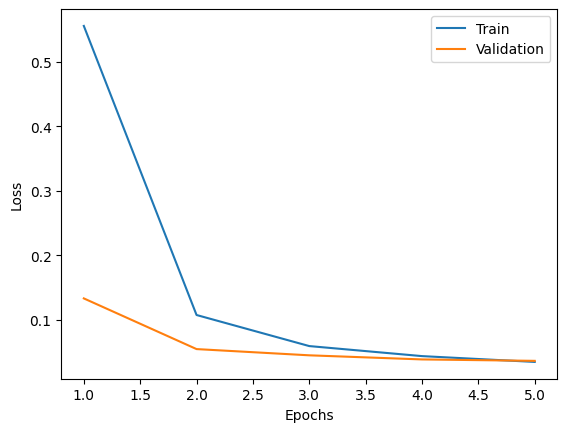

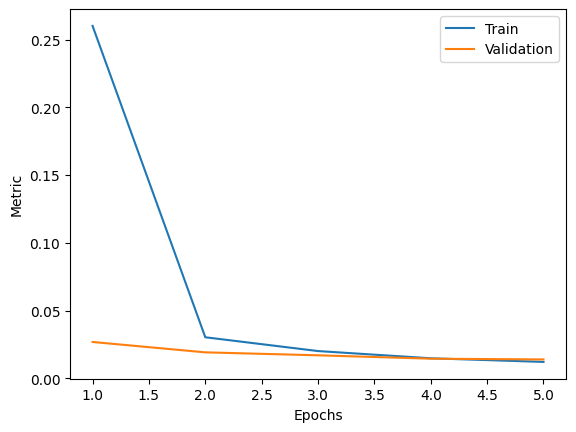

In [1183]:
trainer.plot_history()

In [1184]:
trainer.best_epoch

5

#Get Accuracy, Predictions

In [1185]:
testset = CustomDataset(X_test, y_test)

In [1186]:
test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [1187]:
# Get the prediction and accuracy for the test dataset

predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True)
predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True)


In [1188]:
import torchmetrics
metric = torchmetrics.functional.accuracy
acc_train = metric(predictions_train, target_train,
                   task='multiclass', num_classes=10)
acc_valid = metric(predictions_valid, target_valid,
                   task='multiclass', num_classes=10)
acc_test = metric(predictions_test, target_test,
                  task='multiclass', num_classes=10)

ValueError: ignored

In [ ]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(predictions_test, target_test)*100)
print(accuracy_score(predictions_train, target_train)*100)
print(accuracy_score(predictions_valid, target_valid)*100)

In [ ]:
metric = torchmetrics.functional.f1_score
f1_train = metric(predictions_train, target_train,
                  task='multiclass', num_classes=10)
f1_valid = metric(predictions_valid, target_valid,
                  task='multiclass', num_classes=10)
f1_test = metric(predictions_test, target_test,
                 task='multiclass', num_classes=10)

In [ ]:
# Print Test Accuracy
print('Test f1score', f1_test * 100)
print('Train f1score', f1_train * 100)
print('Valid f1score', f1_valid * 100)

In [ ]:
print(f1_score(predictions_test.numpy(), target_test.numpy(), average='micro') * 100)
print(f1_score(predictions_train.numpy(),
      target_train.numpy(), average='micro') * 100)
print(f1_score(predictions_valid.numpy(),
      target_valid.numpy(), average='micro') * 100)